<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 4)</h2>
        <img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>
    </div>
    <div style="padding: 3px 8px;">
        
1. **Description**:
   - **Idea**: k-mer Representation with One-Hot Encoding / embeding for Neural Network Architecture
   - Treat each k-mer (a sequence of k bases) as a single token.
   - Use one-hot encoding to represent each k-mer.
   - Train a neural network model on the sequence of one-hot encoded k-mers.

2. **Pros**:
   - Captures short-range dependencies and interactions between bases.
   - One-hot encoding is straightforward and easy to implement.
   - Neural networks can potentially learn complex patterns in the data.

3. **Cons**:
   - High dimensionality for larger k values, which can lead to increased computational cost.
   - May not capture long-range dependencies effectively without additional mechanisms like attention.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [18]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, Flatten, Input
from keras.layers import LSTM, SimpleRNN, Bidirectional
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D
from keras import Model

import matplotlib.pyplot as plt
from Utils.VISU import VISU
import itertools

from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer

In [19]:
def read_fasta_file(file_path, family):
    """
    Utils: Convert fasta file to dataframe
    """
    sequences = []
    with open(file_path, 'r') as file:
        current_id = None
        current_sequence = ''
        for line in file:
            if line.startswith('>'):
                if current_id:
                    sequences.append({'id': current_id, 'sequence':current_sequence, 'length':len(current_sequence), 'class': family})
                current_id = line.strip().split('|')[0][1:].strip()
                current_sequence = ''
            else:
                current_sequence += line.strip()
        if current_id:
            sequences.append({'id': current_id, 'sequence':current_sequence, 'length':len(current_sequence), 'class': family})
    
    df = pd.DataFrame(sequences)
    return df

### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [20]:
dataset = pd.read_csv("./Output/Arabidopsis_thaliana_GHLH_and_CYP_gene.csv")
testset = read_fasta_file("./Content/Validation-set/LsbHLH.fasta", 0)
dataset.head()

,id,sequence,length,class
0,AT1G51140.1,AAGTTTCTCTCACGTTCTCTTTTTTAATTTTAATTTCTCGCCGGAA...,2297,0
1,AT1G73830.1,ACTTTCTATTTTCACCAATTTTCAAAAAAAAAATAAAAATTGAAAC...,1473,0
2,AT1G09530.1,AGTTACAGACGATTTGGTCCCCTCTCTTCTCTCTCTGCGTCCGTCT...,2958,0
3,AT1G49770.1,ATGACTAATGCTCAAGAGTTGGGGCAAGAGGGTTTTATGTGGGGCA...,2205,0
4,AT1G68810.1,AAACTTTTGTCTCTTTTTAACTCTCTTAACTTTCGTTTCTTCTCCT...,1998,0


### 3 - Preprocessing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>
        <span style="color: red;">Representation method 1</span> : Kmer-One-Hot-Encoding, one-dimensional representation of a single DNA sequence which consist of concatenation of k-mer one-hot-encoding
    </li></ul>
</h4>

In [30]:
def generate_kmers(k):
    """
    Generate all possible k-mers and return a mapping dictionary with one-hot encoded vectors.
    """
    kmers = [''.join(p) for p in itertools.product('ACGT', repeat=k)]
    one_hot_encoding = np.eye(len(kmers), dtype=int)
    kmer_dict = {kmer: one_hot_encoding[i] for i, kmer in enumerate(kmers)}
    return kmer_dict
    
def seq2kmer(sequence, k=3, sliding_windows=1, as_sentence=False, pad_length=None, pad_char='-'):
    """
    Convert a sequence to k-mers and return list of k-mers or a concatenated string of k-mers.
    """
    if pad_length:
        sequence = sequence.ljust(pad_length, pad_char)
        
    kmer_list = []
    for i in range(0, len(sequence) - k + 1, sliding_windows):
        kmer_list.append(sequence[i:i + k])
    if as_sentence:
        kmer_list = " ".join(kmer_list)
    return kmer_list

def vectorize(sequences, kmer_dict, k=3, step=1, max_pad=None):
    """
    Convert a sequence into a vector using k-mer one-hot encoding.
    """
    kmer_size = 4 ** k
    vector = []
    for seq in sequences:
        one_hot_vector = []
        for i in range(0, len(seq) - k + 1, step):
            try:
                one_hot_vector.extend(kmer_dict[seq[i:i + k]])
            except:
                one_hot_vector.extend([0]*kmer_size)
                
        vector.append(one_hot_vector)
    
    # Handling inequal sequence length using zero padding
    max_len = max_pad if max_pad != None else max(len(arr) for arr in vector)
    for i in range(len(vector)):
        required = max_len - len(vector[i])
        vector[i]+=([0]*required)
        vector[i] = np.array(vector[i])

    return np.array(vector)

In [31]:
k = 3
NUM_CLASS  = 1
kmer_dict = generate_kmers(k)
#SEQ_LENGTH = int(dataset['sequence'].apply(lambda x: len(x)).max())
X = vectorize(dataset['sequence'].tolist(), kmer_dict, k, max_pad=311744)
y = np.array(dataset['class'])
X_test = vectorize(testset['sequence'].tolist(), kmer_dict, k, max_pad=311744)
y_test = np.array(testset['class'])
SEQ_LENGTH = X.shape[1]

In [32]:
X

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [33]:
X_train = X
y_train = y
print("Shapes of train/test splits:")
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

Shapes of train/test splits:
X_train: (380, 311744)
X_test: (122, 311744)
y_train: (380,)
y_test: (122,)


* Utils

In [34]:
def model_checkpoint(model_name):
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/SeqEmbedding1D/"+model_name+".weights.h5", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=True
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )
def plot_curve(history, list_of_metrics):
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Value")
    epochs = history.epoch
    hist = pd.DataFrame(history.history)
    for m in list_of_metrics:
        x = hist[m]
        plt.plot(epochs[1:], x[1:], '.-', label=m, lw=2, )
    plt.legend()

### 4 - Model training and testing

#### 4.1 MODEL 1 : FEED-FORWARD NETWORKS WITHOUT EMBEDDINGS

Model: "FEEDFORWARD1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 256)            │    79,806,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,847,937 (304.60 MB)

 Trainable params: 79,847,937 (304.60 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 814ms/step - accuracy: 0.6129 - loss: 0.6940 - val_accuracy: 0.6053 - val_loss: 0.6313
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 671ms/step - accuracy: 0.8598 - loss: 0.2899 - val_accuracy: 0.5395 - val_loss: 0.7606
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 480ms/step - accuracy: 0.9726 - loss: 0.1032 - val_accuracy: 0.6842 - val_loss: 0.6573
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 434ms/step - accuracy: 0.9826 - loss: 0.0468 - val_accuracy: 0.6711 - val_loss: 0.6357
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 426ms/step - accuracy: 1.0000 - loss: 0.0065 - val_accuracy: 0.6447 - val_loss: 0.6850
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 382ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.6579 - val_loss: 0.7349
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 407ms/step - accuracy: 1.0000 - loss: 8.7897e-04 - val_accuracy: 0.6579 - val_loss: 0.7837
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 427ms/step - accuracy: 1.0000 - loss: 5.5265e-04 - val_accuracy: 0.

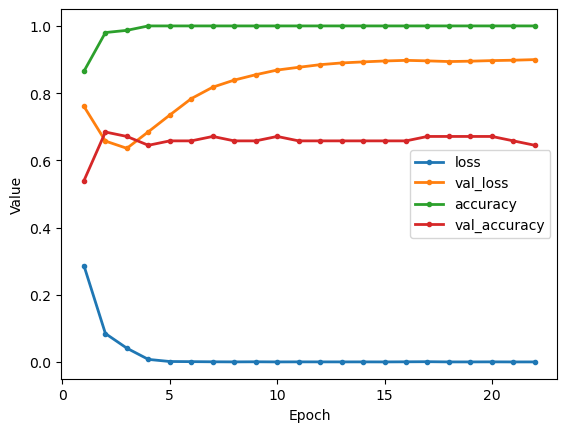

In [35]:
name="FEEDFORWARD1"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=5)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))
plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

#### 4.2 MODEL 2 : CONVOLUTIONAL NEURAL NETWORKS (CNN)

In [ ]:
name="CNN"
def cnn(name=name, layers=2, filters=[16, 32, 64, 100], num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(seq_length,1)))

    for i in range(layers):
        model.add(Conv1D(filters=filters[i], kernel_size=3, activation='relu'))
        model.add(MaxPooling1D(pool_size=2, strides=1))
    model.add(Flatten())

    model.add(BatchNormalization())
    model.add(Dense(num_output, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = cnn(layers=2)
stop_callback = early_stopping(patience=5)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))
plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 311742, 16)     │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 311741, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 311739, 32)     │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 311738, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9975616)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 9975616)        │    39,902,464 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │     9,975,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,879,713 (190.28 MB)

 Trainable params: 29,928,481 (114.17 MB)

 Non-trainable params: 19,951,232 (76.11 MB)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 347s 73s/step - accuracy: 0.5766 - loss: 7.6569 - val_accuracy: 0.4211 - val_loss: 3.2640
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 267s 48s/step - accuracy: 0.8073 - loss: 16.2011 - val_accuracy: 0.5789 - val_loss: 5.1606
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 243s 52s/step - accuracy: 0.9108 - loss: 2.6588 - val_accuracy: 0.5789 - val_loss: 14.2908
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 315s 62s/step - accuracy: 0.9703 - loss: 0.7391 - val_accuracy: 0.5789 - val_loss: 16.7824
Epoch 5/100
2/5 ━━━━━━━━━━━━━━━━━━━━ 4:32 91s/step - accuracy: 1.0000 - loss: 5.3846e-07

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>
        <span style="color: red;">Representation method 2</span> : DNA sequences as k-mer sentence and embedding
    </li></ul>
</h4>

In [ ]:
model_performance = {}

* **Word2Vec**

In [ ]:
k = 3
model_performance[k] = {
    'word2vec': [], 
    'dna2vec':  [], 
}
NUM_CLASS  = 1
X = dataset['sequence'].apply(lambda seq: seq2kmer(seq, k=k, as_sentence=True))
y = np.array(dataset['class'])

In [ ]:
X_test = testset['sequence'].apply(lambda seq: seq2kmer(seq, k=k, as_sentence=True))
y = np.array(testset['class'])

In [ ]:
X.head()

In [ ]:
# Train Word2Vec model
w2v_model = Word2Vec(sentences=[sequence.split() for sequence in X.tolist()], vector_size=100, window=5, min_count=1, workers=4)
word_index = w2v_model.wv.key_to_index
word_index = {key: value + 1 for key, value in word_index.items()}

In [ ]:
# Prepare the embedding matrix
embedding_dim = 100
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    if word in w2v_model.wv.key_to_index.keys():
        embedding_matrix[i] = w2v_model.wv[w2v_model.wv.key_to_index[word]]

In [ ]:
# Prepare the data for the neural network
def texts_to_sequences(texts, word_index):
        sequences = []
        for text in texts:
            seq = []
            for word in text.split():
                index = word_index.get(word)
                if index is not None:
                    seq.append(index)
            sequences.append(seq)
        return sequences

# text to seq
X = texts_to_sequences(X.tolist(), word_index)
X_test = texts_to_sequences(X_test.tolist(), word_index)

# padding
SEQ_LENGTH = max(max(len(seq) for seq in X), max(len(seq) for seq in X_test))
X = pad_sequences(X, maxlen=SEQ_LENGTH)
X_test = pad_sequences(X_test, maxlen=SEQ_LENGTH)

In [ ]:
# Train test split - we do not need to make train test split as we already have the two dataset separated
# X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y)

X_train = X
y_train = y
print("Shapes of train/test splits:")
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

**1. FEED FORWARD MODEL**

In [175]:
name="FF-SIMPLE-EMBEDDING"
def model1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH, embedding_matrix=embedding_matrix):
    # embedding layer
    embedding_layer = Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim, trainable=False)
    embedding_layer.build((1,))
    embedding_layer.set_weights([embedding_matrix])

    # input layer
    int_sequences_input = Input(shape=(seq_length,), dtype="int32")

    # stacked layer
    embedded_sequences = embedding_layer(int_sequences_input)
    x = Flatten()(embedded_sequences)
    x = Dense(256, activation='relu')(x)
    x = Dropout(rate=0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(rate=0.5)(x)
    #x = Dense(64, activation='relu')(x)
    #x = Dropout(rate=0.5)(x)
    pred = Dense(num_output, activation='sigmoid')(x)
    model = Model(int_sequences_input, pred, name=name)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = model1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))
plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

# Save model performance for report
model_performance[k]['word2vec'].append(scores[1]*100)

Model: "FF-SIMPLE-EMBEDDING"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_42 (InputLayer)     │ (None, 4868)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_42 (Embedding)        │ (None, 4868, 100)      │       409,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_25 (Flatten)            │ (None, 486800)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 256)            │   124,621,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 125,063,781 (477.08 MB)

 Trainable params: 124,654,081 (475.52 MB)

 Non-trainable params: 409,700 (1.56 MB)

Epoch 1/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.5653 - loss: 2.6842 - val_accuracy: 0.6885 - val_loss: 2.3251
Epoch 2/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.7797 - loss: 4.0642 - val_accuracy: 0.6721 - val_loss: 3.5919
Epoch 3/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.8165 - loss: 4.3631 - val_accuracy: 0.7541 - val_loss: 2.4946
Epoch 4/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.8903 - loss: 2.3928 - val_accuracy: 0.6721 - val_loss: 3.3876
Epoch 5/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 827ms/step - accuracy: 0.8613 - loss: 3.6046 - val_accuracy: 0.6721 - val_loss: 4.3119
Epoch 6/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 735ms/step - accuracy: 0.8966 - loss: 2.0806 - val_accuracy: 0.6230 - val_loss: 4.6926
Epoch 7/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 487ms/step - accuracy: 0.8894 - loss: 2.9965 - val_accuracy: 0.6230 - val_loss: 5.3709
Epoch 8/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 576ms/step - accuracy: 0.9133 - loss: 2.6782 - val_accuracy: 0.6557 - val_loss: 5.4475
Epo

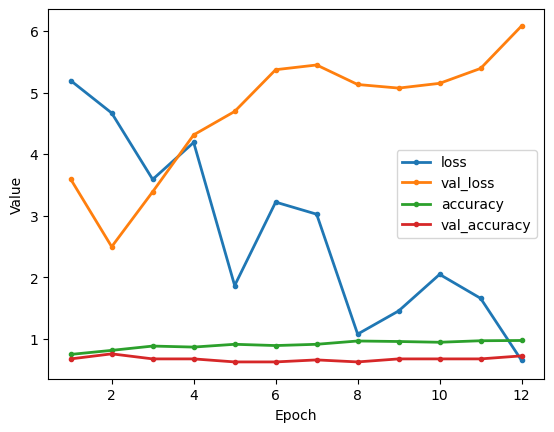

In [176]:
plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

**2. CNN MODEL**

In [177]:
name="CNN-SIMPLE-EMBEDDING"
def model2(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH, embedding_matrix=embedding_matrix):
    # embedding layer
    embedding_layer = Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim, trainable=False)
    embedding_layer.build((1,))
    embedding_layer.set_weights([embedding_matrix])

    # input layer
    int_sequences_input = Input(shape=(seq_length,), dtype="int32")
    # stacked layer
    embedded_sequences = embedding_layer(int_sequences_input)
    x = Conv1D(filters=16, kernel_size=3, padding='same', activation="relu")(embedded_sequences)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(filters=32, kernel_size=3, padding='same', activation="relu")(embedded_sequences)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(filters=64, kernel_size=3, padding='same', activation="relu")(embedded_sequences)
    x = MaxPooling1D(pool_size=2)(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)
    pred = Dense(num_output, activation='sigmoid')(x)
    model = Model(int_sequences_input, pred, name=name)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = model2()
stop_callback = early_stopping(patience=15)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))
plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

# Save model performance for report
model_performance[k]['word2vec'].append(scores[1]*100)

Model: "CNN-SIMPLE-EMBEDDING"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_43 (InputLayer)     │ (None, 4868)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_43 (Embedding)        │ (None, 4868, 100)      │       409,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_46 (Conv1D)              │ (None, 4868, 64)       │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_46 (MaxPooling1D) │ (None, 2434, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 2434, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_26 (Flatten)            │ (None, 155776)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 1)              │       155,777 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 584,997 (2.23 MB)

 Trainable params: 175,169 (684.25 KB)

 Non-trainable params: 409,828 (1.56 MB)

Epoch 1/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 236ms/step - accuracy: 0.5673 - loss: 7.2357 - val_accuracy: 0.4426 - val_loss: 4.8656
Epoch 2/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step - accuracy: 0.6553 - loss: 3.1741 - val_accuracy: 0.6557 - val_loss: 2.2558
Epoch 3/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step - accuracy: 0.8881 - loss: 0.7499 - val_accuracy: 0.6557 - val_loss: 1.4839
Epoch 4/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 230ms/step - accuracy: 0.8708 - loss: 1.0114 - val_accuracy: 0.6885 - val_loss: 1.6745
Epoch 5/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 229ms/step - accuracy: 0.9780 - loss: 0.2294 - val_accuracy: 0.6721 - val_loss: 2.2099
Epoch 6/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 204ms/step - accuracy: 0.9613 - loss: 0.1530 - val_accuracy: 0.7213 - val_loss: 1.4252
Epoch 7/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 267ms/step - accuracy: 1.0000 - loss: 6.7098e-05 - val_accuracy: 0.6393 - val_loss: 1.3694
Epoch 8/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step - accuracy: 1.0000 - loss: 4.9393e-05 - val_accuracy: 0.6393 - v

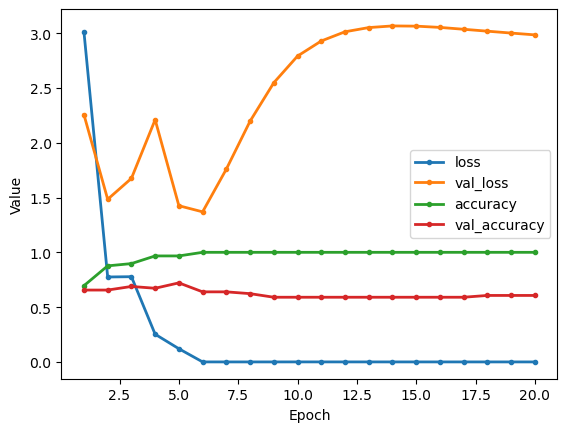

In [178]:
plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

**3. LSTM**

In [179]:
name="LSTM-SIMPLE-EMBEDDING"
def model3(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH, embedding_matrix=embedding_matrix):
    # embedding layer
    embedding_layer = Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim, trainable=False)
    embedding_layer.build((1,))
    embedding_layer.set_weights([embedding_matrix])

    # input layer
    int_sequences_input = Input(shape=(seq_length,), dtype="int32")

    # stacked layer
    embedded_sequences = embedding_layer(int_sequences_input)
    x = LSTM(100)(embedded_sequences)
    pred = Dense(num_output, activation='sigmoid')(x)
    model = Model(int_sequences_input, pred, name=name)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = model3()
stop_callback = early_stopping(patience=15)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))
plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

# Save model performance for report
model_performance[k]['word2vec'].append(scores[1]*100)

Model: "LSTM-SIMPLE-EMBEDDING"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_44 (InputLayer)     │ (None, 4868)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_44 (Embedding)        │ (None, 4868, 100)      │       409,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 490,201 (1.87 MB)

 Trainable params: 80,501 (314.46 KB)

 Non-trainable params: 409,700 (1.56 MB)

Epoch 1/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - accuracy: 0.5159 - loss: 0.7073 - val_accuracy: 0.5902 - val_loss: 0.6820
Epoch 2/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.6165 - loss: 0.6225 - val_accuracy: 0.6230 - val_loss: 0.6948
Epoch 3/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.7290 - loss: 0.5803 - val_accuracy: 0.5902 - val_loss: 0.7042
Epoch 4/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step - accuracy: 0.7466 - loss: 0.5628 - val_accuracy: 0.5246 - val_loss: 0.7148
Epoch 5/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step - accuracy: 0.7444 - loss: 0.5436 - val_accuracy: 0.5574 - val_loss: 0.7231
Epoch 6/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - accuracy: 0.8136 - loss: 0.5027 - val_accuracy: 0.5410 - val_loss: 0.7369
Epoch 7/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.8325 - loss: 0.4475 - val_accuracy: 0.5082 - val_loss: 0.7492
Epoch 8/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.8776 - loss: 0.4065 - val_accuracy: 0.4918 - val_loss: 0.7727
Epoch 9/

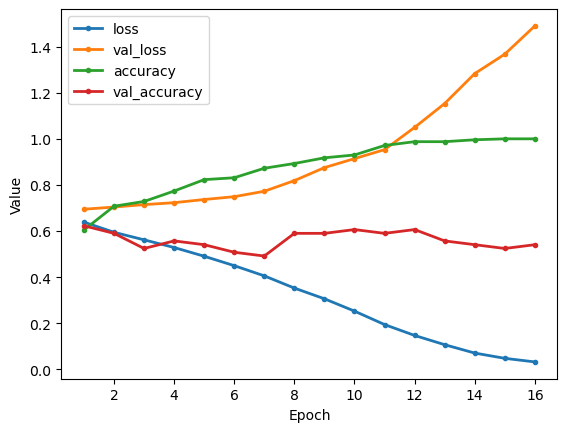

In [180]:
plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

**4. LSTM AND CNN**

In [181]:
name="CNN_BiLSTM-SIMPLE-EMBEDDING"
def model4(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH, embedding_matrix=embedding_matrix):
    # embedding layer
    embedding_layer = Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim, trainable=False)
    embedding_layer.build((1,))
    embedding_layer.set_weights([embedding_matrix])

    # input layer
    int_sequences_input = Input(shape=(seq_length,), dtype="int32")

    # stacked layer
    embedded_sequences = embedding_layer(int_sequences_input)
    x = Conv1D(filters=32, kernel_size=3, padding='same', activation="relu")(embedded_sequences)
    x = MaxPooling1D(pool_size=2)(x)
    x = Bidirectional(LSTM(100))(x)
    pred = Dense(num_output, activation='sigmoid')(x)
    model = Model(int_sequences_input, pred, name=name)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = model4()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))
plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

# Save model performance for report
model_performance[k]['word2vec'].append(scores[1]*100)

Model: "CNN_BiLSTM-SIMPLE-EMBEDDING"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_45 (InputLayer)     │ (None, 4868)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_45 (Embedding)        │ (None, 4868, 100)      │       409,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_47 (Conv1D)              │ (None, 4868, 32)       │         9,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_47 (MaxPooling1D) │ (None, 2434, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ (None, 200)            │       106,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 525,933 (2.01 MB)

 Trainable params: 116,233 (454.04 KB)

 Non-trainable params: 409,700 (1.56 MB)

Epoch 1/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.4977 - loss: 0.6976 - val_accuracy: 0.5574 - val_loss: 0.6867
Epoch 2/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.6052 - loss: 0.6549 - val_accuracy: 0.5246 - val_loss: 0.6821
Epoch 3/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.6911 - loss: 0.6516 - val_accuracy: 0.4754 - val_loss: 0.6870
Epoch 4/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.7159 - loss: 0.6309 - val_accuracy: 0.5082 - val_loss: 0.7030
Epoch 5/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.6831 - loss: 0.6044 - val_accuracy: 0.5082 - val_loss: 0.7109
Epoch 6/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.7246 - loss: 0.5920 - val_accuracy: 0.4918 - val_loss: 0.7093
Epoch 7/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.7527 - loss: 0.5479 - val_accuracy: 0.5082 - val_loss: 0.7706
Epoch 8/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.7302 - loss: 0.5304 - val_accuracy: 0.5082 - val_loss: 0.7687
Epoch 9/40
4/4

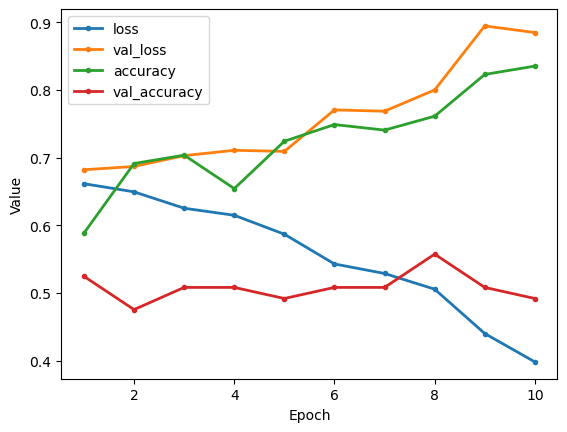

In [182]:
plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

* **Dna2Vec embedding**

In [183]:
# load pretrained model to use embedding representation of k-mer

from Transfer_Learning.dna2vec.multi_k_model import MultiKModel
filepath = 'Transfer_Learning/dna2vec/pretrained/dna2vec-20161219-0153-k3to8-100d-10c-29320Mbp-sliding-Xat.w2v'
mk_model = MultiKModel(filepath)

In [184]:
# Prepare the embedding matrix
embedding_dim = 100
embedding_matrix_pretrain = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    if word in w2v_model.wv.key_to_index.keys():
        embedding_matrix_pretrain[i] = mk_model.vector(word)

**1. FEED FORWARD MODEL**

In [185]:
name="FF-DNA2VEC-EMBEDDING"
def model1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH, embedding_matrix=embedding_matrix):
    # embedding layer
    embedding_layer = Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim, trainable=False)
    embedding_layer.build((1,))
    embedding_layer.set_weights([embedding_matrix])

    # input layer
    int_sequences_input = Input(shape=(seq_length,), dtype="int32")

    # stacked layer
    embedded_sequences = embedding_layer(int_sequences_input)
    x = Flatten()(embedded_sequences)
    x = Dense(256, activation='relu')(x)
    x = Dropout(rate=0.2)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(rate=0.2)(x)
    #x = Dense(64, activation='relu')(x)
    #x = Dropout(rate=0.2)(x)
    pred = Dense(num_output, activation='sigmoid')(x)
    model = Model(int_sequences_input, pred, name=name)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = model1(embedding_matrix=embedding_matrix_pretrain)
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))
plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

# Save model performance for report
model_performance[k]['dna2vec'].append(scores[1]*100)

Model: "FF-DNA2VEC-EMBEDDING"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_46 (InputLayer)     │ (None, 4868)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_46 (Embedding)        │ (None, 4868, 100)      │       409,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_27 (Flatten)            │ (None, 486800)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 256)            │   124,621,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_81 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 125,063,781 (477.08 MB)

 Trainable params: 124,654,081 (475.52 MB)

 Non-trainable params: 409,700 (1.56 MB)

Epoch 1/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.5353 - loss: 4.7566 - val_accuracy: 0.5574 - val_loss: 4.6253
Epoch 2/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 866ms/step - accuracy: 0.6897 - loss: 2.9140 - val_accuracy: 0.4754 - val_loss: 2.0299
Epoch 3/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 893ms/step - accuracy: 0.6779 - loss: 2.5773 - val_accuracy: 0.5738 - val_loss: 2.2585
Epoch 4/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 837ms/step - accuracy: 0.8457 - loss: 1.3127 - val_accuracy: 0.6066 - val_loss: 2.1734
Epoch 5/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.9046 - loss: 0.5386 - val_accuracy: 0.6393 - val_loss: 0.8422
Epoch 6/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 719ms/step - accuracy: 0.9293 - loss: 0.5107 - val_accuracy: 0.7049 - val_loss: 1.0199
Epoch 7/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 445ms/step - accuracy: 0.9631 - loss: 0.2321 - val_accuracy: 0.6885 - val_loss: 1.7157
Epoch 8/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 462ms/step - accuracy: 0.9740 - loss: 0.1108 - val_accuracy: 0.7049 - val_loss: 1.042

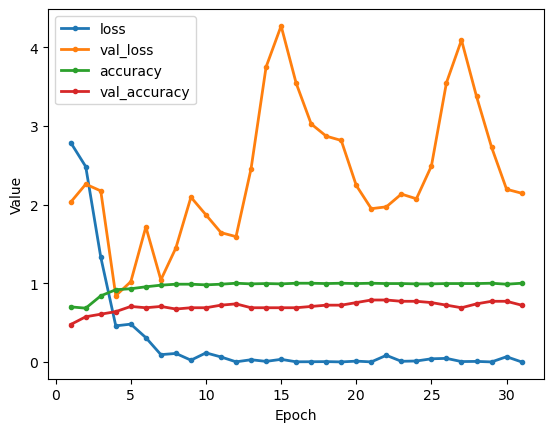

In [186]:
plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

**2. CNN MODEL**

In [187]:
name="CNN-DNA2VEC-EMBEDDING"
def model2(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH, embedding_matrix=embedding_matrix):
    # embedding layer
    embedding_layer = Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim, trainable=False)
    embedding_layer.build((1,))
    embedding_layer.set_weights([embedding_matrix])

    # input layer
    int_sequences_input = Input(shape=(seq_length,), dtype="int32")

    # stacked layer
    embedded_sequences = embedding_layer(int_sequences_input)
    x = Conv1D(filters=16, kernel_size=3, padding='same', activation="relu")(embedded_sequences)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(filters=32, kernel_size=3, padding='same', activation="relu")(embedded_sequences)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(filters=64, kernel_size=3, padding='same', activation="relu")(embedded_sequences)
    x = MaxPooling1D(pool_size=2)(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)
    pred = Dense(num_output, activation='sigmoid')(x)
    model = Model(int_sequences_input, pred, name=name)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = model2(embedding_matrix=embedding_matrix_pretrain)
stop_callback = early_stopping(patience=15)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))
plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

# Save model performance for report
model_performance[k]['dna2vec'].append(scores[1]*100)

Model: "CNN-DNA2VEC-EMBEDDING"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_47 (InputLayer)     │ (None, 4868)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_47 (Embedding)        │ (None, 4868, 100)      │       409,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_50 (Conv1D)              │ (None, 4868, 64)       │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_50 (MaxPooling1D) │ (None, 2434, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 2434, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_28 (Flatten)            │ (None, 155776)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_82 (Dense)                │ (None, 1)              │       155,777 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 584,997 (2.23 MB)

 Trainable params: 175,169 (684.25 KB)

 Non-trainable params: 409,828 (1.56 MB)

Epoch 1/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 253ms/step - accuracy: 0.5746 - loss: 7.4036 - val_accuracy: 0.5574 - val_loss: 1.4165
Epoch 2/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step - accuracy: 0.6928 - loss: 2.5728 - val_accuracy: 0.5902 - val_loss: 0.7974
Epoch 3/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step - accuracy: 0.9019 - loss: 0.4477 - val_accuracy: 0.5574 - val_loss: 1.1162
Epoch 4/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step - accuracy: 0.8964 - loss: 0.5322 - val_accuracy: 0.6066 - val_loss: 0.8170
Epoch 5/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 231ms/step - accuracy: 0.9867 - loss: 0.0268 - val_accuracy: 0.6721 - val_loss: 0.6625
Epoch 6/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 247ms/step - accuracy: 0.9735 - loss: 0.0814 - val_accuracy: 0.6557 - val_loss: 0.6369
Epoch 7/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.6557 - val_loss: 0.6327
Epoch 8/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 220ms/step - accuracy: 1.0000 - loss: 1.4258e-04 - val_accuracy: 0.6557 - val_l

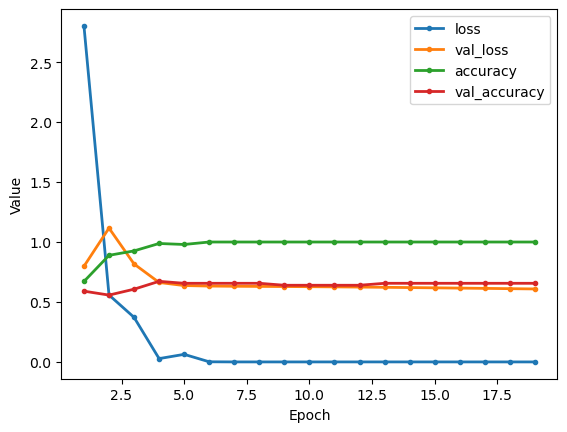

In [188]:
plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

**3. LSTM**

In [189]:
name="LSTM-DNA2VEC-EMBEDDING"
def model3(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH, embedding_matrix=embedding_matrix):
    # embedding layer
    embedding_layer = Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim, trainable=False)
    embedding_layer.build((1,))
    embedding_layer.set_weights([embedding_matrix])

    # input layer
    int_sequences_input = Input(shape=(seq_length,), dtype="int32")

    # stacked layer
    embedded_sequences = embedding_layer(int_sequences_input)
    x = LSTM(100)(embedded_sequences)
    pred = Dense(num_output, activation='sigmoid')(x)
    model = Model(int_sequences_input, pred, name=name)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = model3(embedding_matrix=embedding_matrix_pretrain)
stop_callback = early_stopping(patience=15)
save_callback = model_checkpoint(name)

history = model.fit(X_train, y_train, validation_split=0.2, epochs=40, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
scores = model.evaluate(X_test, y_test, verbose=0)
print("\nAccuracy: %.2f%%" % (scores[1]*100))
model_performance[k]['dna2vec'].append(scores[1]*100)

Model: "LSTM-DNA2VEC-EMBEDDING"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_48 (InputLayer)     │ (None, 4868)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_48 (Embedding)        │ (None, 4868, 100)      │       409,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 490,201 (1.87 MB)

 Trainable params: 80,501 (314.46 KB)

 Non-trainable params: 409,700 (1.56 MB)

Epoch 1/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.4921 - loss: 0.6979 - val_accuracy: 0.5410 - val_loss: 0.6901
Epoch 2/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step - accuracy: 0.5671 - loss: 0.6732 - val_accuracy: 0.5574 - val_loss: 0.6989
Epoch 3/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step - accuracy: 0.6070 - loss: 0.6433 - val_accuracy: 0.5410 - val_loss: 0.7060
Epoch 4/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.5811 - loss: 0.6522 - val_accuracy: 0.4918 - val_loss: 0.7013
Epoch 5/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.6592 - loss: 0.6251 - val_accuracy: 0.4918 - val_loss: 0.7077
Epoch 6/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step - accuracy: 0.7646 - loss: 0.5926 - val_accuracy: 0.5082 - val_loss: 0.7299
Epoch 7/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - accuracy: 0.7096 - loss: 0.5641 - val_accuracy: 0.4918 - val_loss: 0.7905
Epoch 8/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.7549 - loss: 0.5093 - val_accuracy: 0.4262 - val_loss: 0.8699
Epoch 9/

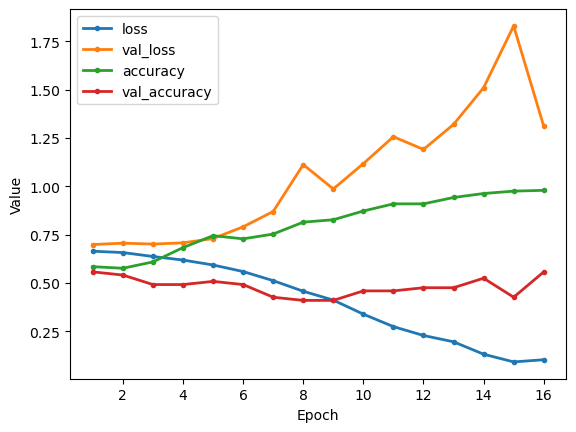

In [190]:
plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

**4. LSTM AND CNN**

In [191]:
name="CNN_BiLSTM-DNA2VEC-EMBEDDING"
def model4(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH, embedding_matrix=embedding_matrix):
    # embedding layer
    embedding_layer = Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim, trainable=False)
    embedding_layer.build((1,))
    embedding_layer.set_weights([embedding_matrix])

    # input layer
    int_sequences_input = Input(shape=(seq_length,), dtype="int32")

    # stacked layer
    embedded_sequences = embedding_layer(int_sequences_input)
    x = Conv1D(filters=32, kernel_size=3, padding='same', activation="relu")(embedded_sequences)
    x = MaxPooling1D(pool_size=2)(x)
    x = Bidirectional(LSTM(100))(x)
    pred = Dense(num_output, activation='sigmoid')(x)
    model = Model(int_sequences_input, pred, name=name)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = model4(embedding_matrix=embedding_matrix_pretrain)
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

history = model.fit(X_train, y_train, validation_split=0.2, epochs=40, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
scores = model.evaluate(X_test, y_test, verbose=0)
print("\nAccuracy: %.2f%%" % (scores[1]*100))
model_performance[k]['dna2vec'].append(scores[1]*100)

Model: "CNN_BiLSTM-DNA2VEC-EMBEDDING"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_49 (InputLayer)     │ (None, 4868)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_49 (Embedding)        │ (None, 4868, 100)      │       409,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_51 (Conv1D)              │ (None, 4868, 32)       │         9,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_51 (MaxPooling1D) │ (None, 2434, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_9 (Bidirectional) │ (None, 200)            │       106,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_84 (Dense)                │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 525,933 (2.01 MB)

 Trainable params: 116,233 (454.04 KB)

 Non-trainable params: 409,700 (1.56 MB)

Epoch 1/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.5330 - loss: 0.6912 - val_accuracy: 0.5574 - val_loss: 0.6951
Epoch 2/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.5799 - loss: 0.6747 - val_accuracy: 0.5574 - val_loss: 0.6932
Epoch 3/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.5601 - loss: 0.6746 - val_accuracy: 0.5574 - val_loss: 0.6920
Epoch 4/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.5837 - loss: 0.6582 - val_accuracy: 0.5574 - val_loss: 0.6973
Epoch 5/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.6008 - loss: 0.6396 - val_accuracy: 0.5574 - val_loss: 0.7075
Epoch 6/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.5988 - loss: 0.6303 - val_accuracy: 0.4426 - val_loss: 0.7065
Epoch 7/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.7028 - loss: 0.6148 - val_accuracy: 0.5410 - val_loss: 0.7484
Epoch 8/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.7019 - loss: 0.5840 - val_accuracy: 0.4590 - val_loss: 0.7243
Epoch 9/40
4

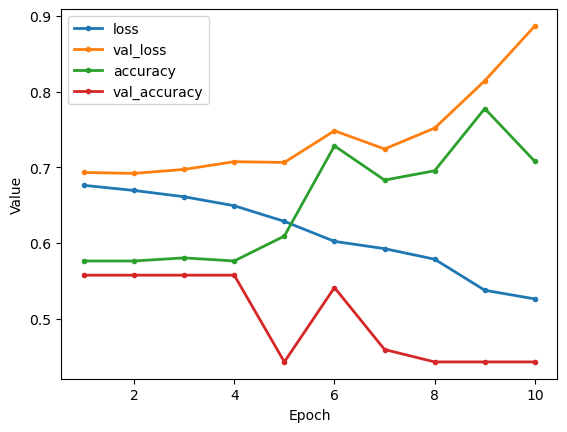

In [192]:
plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

* SAVE IN DATAFRAME

In [ ]:
def performance_to_dataframe(model_performance):
    data = []
    for k, performance in model_performance.items():
        for model_type, accuracies in performance.items():
            for accuracy in accuracies:
                data.append({'k': k, 'model_type': model_type, 'accuracy': accuracy})
    df = pd.DataFrame(data)
    return df

# Convert the model performance dictionary to a DataFrame
df = performance_to_dataframe(model_performance)
df.to_csv(f'./Output/Embedding/result_k_{k}.csv', index=False)

# Print the DataFrame
df

* <span style="color: blue;">Let's summarize the result</span>

In [5]:
fs_result_k3 = pd.read_csv("./Output/Embedding/result_k_3.csv")
fs_result_k4 = pd.read_csv("./Output/Embedding/result_k_4.csv")
fs_result_k5 = pd.read_csv("./Output/Embedding/result_k_5.csv")
fs_result_k6 = pd.read_csv("./Output/Embedding/result_k_6.csv")

In [8]:
df = pd.DataFrame({
    'k3_word2vec': fs_result_k3[fs_result_k3['model_type'] == "word2vec"]["accuracy"].values,
    'k3_pretrain': fs_result_k3[fs_result_k3['model_type'] == "dna2vec"]["accuracy"].values,
    'k4_word2vec': fs_result_k4[fs_result_k4['model_type'] == "word2vec"]["accuracy"].values,
    'k4_pretrain': fs_result_k4[fs_result_k4['model_type'] == "dna2vec"]["accuracy"].values,
    'k5_word2vec': fs_result_k5[fs_result_k5['model_type'] == "word2vec"]["accuracy"].values,
    'k5_pretrain': fs_result_k5[fs_result_k5['model_type'] == "dna2vec"]["accuracy"].values,
    'k6_word2vec': fs_result_k6[fs_result_k6['model_type'] == "word2vec"]["accuracy"].values,
    'k6_pretrain': fs_result_k6[fs_result_k6['model_type'] == "dna2vec"]["accuracy"].values,
})

iterable = [["k=3", "k=4", "k=5", "k=6"], ["word2vec", "dna2vec"]]
index = pd.MultiIndex.from_product(iterable, names=["k_mer", "accuracy per embedding method "])
df.index = ["FEED FORWARD MODEL", "CNN MODEL", "LSTM MODEL", "LSTM-CNN MODEL"]
df.columns = index

# Highlight best performance for each model
def highlight_best_scores(s):
    is_max = s == s.max()
    return ['font-weight:bold; color: red' if v else '' for v in is_max]

df_style = df.style.apply(highlight_best_scores, axis=1)
display(df_style)

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>
        <span style="color: red;">Representation method 3</span> : k-mer Pretrained Transformer based DNABERT
    </li></ul>
</h4>

Paper: 
- https://academic.oup.com/bioinformatics/article/37/15/2112/6128680
- https://github.com/jerryji1993/DNABERT